In [112]:
#!python -m pip install torch torchvision torchaudio
#!python -m pip install tensorboard

In [113]:
import torch
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [114]:
#importer un datasets prefait (MNIST)

traning_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

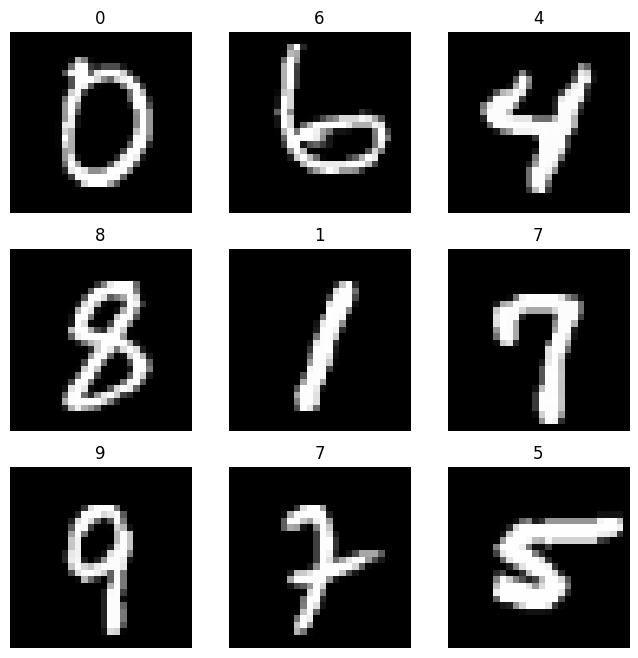

In [115]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(traning_dataset), size=(1,)).item()
    img, label = traning_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [116]:
from torch.utils.data import DataLoader
batch_size = 64

train_dataloader = DataLoader(traning_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X ", X.shape)
    print("Shape of y: ", y.shape)
    break

Shape of X  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64])


In [117]:
train_features, train_labels = next(iter(train_dataloader))
train_features.shape

torch.Size([64, 1, 28, 28])

In [118]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, dims):
        super(MLP, self).__init__()
        self.fcs = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(len(dims)-1)]
        )
        self.act = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        for layer in self.fcs:
            x =layer(x)
            x = self.act(x)
        return x

In [119]:
input_dim = 28*28
output_dim = 10
model = MLP([input_dim, 128, 128, output_dim])

In [120]:
model

MLP(
  (fcs): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [121]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [122]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        ypred = model(X)
        loss = loss_fn(ypred, y)


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset)}]")
    
def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            ypred = model(X)
            test_loss += loss_fn(ypred, y).item()
            correct += (ypred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader.dataset)
    correct /= len(dataloader.dataset)
    print(f"Test loss: {test_loss:>8f} | test accuracy: {correct * 100:>7f}")

In [123]:
# epochs = 10
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(train_dataloader, model, loss_fn, optimizer)
#     test_loop(test_dataloader, model, loss_fn)
# print("Done!")

In [124]:
#importer un datasets prefait (MNIST)

traning_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [125]:
from torch.utils.data import ConcatDataset

mean, std = 0,0

combined_data = ConcatDataset([traning_dataset, test_dataset])

for image, label in combined_data:
    image = image.view(28*28)
    mean += image.mean()
    std += image.std().sum()

mean/= len(combined_data)
std /= len(combined_data)

print(mean, std)

tensor(0.1325) tensor(0.3039)


In [126]:
#importer un datasets prefait (MNIST)

traning_dataset_v2 = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize((mean), (std))])
)

test_dataset_v2 = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize((mean), (std))])
)

In [127]:
from torch.utils.data import ConcatDataset

mean, std = 0,0

combined_data = ConcatDataset([traning_dataset_v2, test_dataset_v2])

for image, label in combined_data:
    image = image.view(28*28)
    mean += image.mean()
    std += image.std().sum()

mean/= len(combined_data)
std /= len(combined_data)

print(mean, std)

tensor(1.6252e-06) tensor(1.0000)


In [128]:
# epochs = 10
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(train_dataloader, model, loss_fn, optimizer)
#     test_loop(test_dataloader, model, loss_fn)
# print("Done!")

In [129]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Accélérateur: {device}")

input_dim = 28*28
output_dim = 10 #Nombre de classe
model = MLP([input_dim, 128, 128, output_dim]).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) 

Accélérateur: cpu


In [130]:

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist_experiment_1')
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    model.train()
    epoch_loss = 0
    correct = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss / len(dataloader), correct / len(dataloader.dataset) * 100

# Training loop with added graphing
def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model
        train_loss, accuracy = train_loop(dataloader_train, model, loss_fn, optimizer, batch_size)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': accuracy}, epoch)

        # Test the model
        test_loss, accuracy = test_loop(dataloader_test, model, loss_fn)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': accuracy}, epoch)

        print(f"Epoch {epoch+1}/{epochs} complete\n")

train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs, batch_size)

Epoch 1/10
Epoch 1/10 complete

Epoch 2/10
Epoch 2/10 complete

Epoch 3/10
Epoch 3/10 complete

Epoch 4/10
Epoch 4/10 complete

Epoch 5/10
Epoch 5/10 complete

Epoch 6/10
Epoch 6/10 complete

Epoch 7/10
Epoch 7/10 complete

Epoch 8/10
Epoch 8/10 complete

Epoch 9/10
Epoch 9/10 complete

Epoch 10/10
Epoch 10/10 complete



In [131]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*14*14, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    
    def forward(self, x):
        x = self.conv_stack(x)
        x = self.mlp(x)
        return x

In [132]:
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3)

In [133]:
writer = SummaryWriter('runs/mnist_experiment_2')
train_and_test(train_dataloader, test_dataloader, cnn, loss_fn, optimizer, epochs, batch_size)

Epoch 1/10
Epoch 1/10 complete

Epoch 2/10
Epoch 2/10 complete

Epoch 3/10
Epoch 3/10 complete

Epoch 4/10
Epoch 4/10 complete

Epoch 5/10
Epoch 5/10 complete

Epoch 6/10
Epoch 6/10 complete

Epoch 7/10
Epoch 7/10 complete

Epoch 8/10
Epoch 8/10 complete

Epoch 9/10
Epoch 9/10 complete

Epoch 10/10
Epoch 10/10 complete



In [134]:
#!python -m pip install onnx
#!python -m pip install onnxscript
#!python -m pip install onnxruntime


In [135]:
cnn.to("cpu")
torch_input = torch.randn(1, 1, 28, 28)
onnx_program = torch.onnx.export(
    cnn,
    torch_input,
    "model.onnx",
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    opset_version=11,
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    },
)

In [136]:
import onnxruntime

onnx_input = [torch_input]
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")

ort_session = onnxruntime.InferenceSession("./model.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

# onnxruntime returns a list of outputs
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]

Input length: 1
Sample input: [tensor([[[[-1.3741e+00,  3.9748e-01,  5.7270e-01,  1.1509e-01, -1.4141e-01,
            6.4125e-02,  1.1042e+00,  3.7835e-01, -1.1949e+00, -6.0085e-01,
            5.5973e-01, -1.0878e+00, -3.3833e-01, -7.4809e-01,  1.9670e+00,
            4.2096e-01,  5.1701e-01, -4.5877e-02, -3.6588e-01, -1.8129e-01,
           -1.0295e-01,  1.8235e-01, -1.1372e+00,  8.0638e-01, -1.2078e+00,
           -1.3751e+00,  1.4226e+00,  5.1749e-01],
          [-1.8715e+00, -1.3260e+00,  7.2624e-02, -8.4867e-01, -1.2534e+00,
            6.9968e-01, -4.5868e-01,  1.0252e+00, -5.1438e-01,  6.1551e-01,
            4.1050e-01, -1.6398e+00,  1.0655e+00, -5.5289e-01, -5.2404e-01,
            1.7268e-01, -9.8505e-01,  2.1879e+00, -2.9261e+00, -8.3165e-01,
            5.9078e-01, -2.5902e-01, -8.7719e-01, -3.7393e-02,  5.3406e-01,
           -2.4005e+00,  3.4399e-01,  7.4295e-01],
          [-2.6156e-01, -5.1278e-01,  9.2012e-02, -1.0566e+00,  8.6395e-01,
           -7.6069e-01, -3.0496

In [137]:
torch_outputs = cnn(torch_input)

assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnxruntime_output in zip(torch_outputs, onnxruntime_outputs):
    torch.testing.assert_close(torch_output, torch.tensor(onnxruntime_output))

print("PyTorch and ONNX Runtime output matched!")
print(f"Output length: {len(onnxruntime_outputs)}")
print(f"Sample output: {onnxruntime_outputs}")

PyTorch and ONNX Runtime output matched!
Output length: 1
Sample output: [[ -5.839282   -3.6005633  10.286593   -2.2662294  -3.691333  -10.707891
   -5.088867    1.1821382   6.063161   -9.791163 ]]
